<a href="https://colab.research.google.com/github/Mounish2023/fastaicourse/blob/main/Mid_Level_Data_API_SiamesePair.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from fastai.vision.all import *

In [ ]:
path = untar_data(URLs.PETS)
files = get_image_files(path/"images")

In [ ]:
class SiameseImage(fastuple):
  def show(self, ctx=None, **kwargs):
    img1, img2, same_breed= self
    if not isinstance(img1, Tensor):
      if img2.size!=img1.size:
        img2 = img2.resize(img1.size)
      t1,t2 = tensor(img1), tensor(img2)
      t1,t2 = t1.permute(2,0,1), t2.permute(2,0,1)
    else:
      t1, t2 = img1, img2
    line = t1.new_zeros(t1.shape[0],t1.shape[1],10)
    print(t1.shape)
    print(t1.shape[0])
    print(t1.shape[1])
    return show_image(torch.cat([t1,line,t2], dim=2),
                      title=same_breed,ctx=ctx)

torch.Size([3, 500, 479])
3
500


<Axes: title={'center': 'True'}>

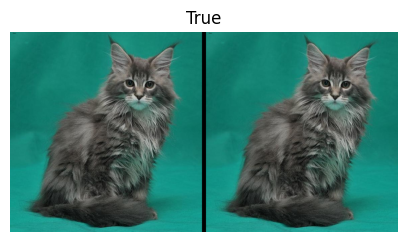

In [ ]:
img = PILImage.create(files[0])
s= SiameseImage(img, img, True)
s.show()


torch.Size([3, 500, 479])
3
500


<Axes: title={'center': 'False'}>

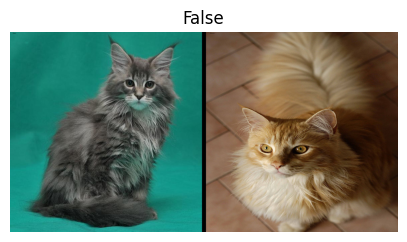

In [ ]:
img1 = PILImage.create(files[1])
s1 = SiameseImage(img, img1, False)
s1.show()

torch.Size([3, 224, 224])
3
224


<Axes: title={'center': 'False'}>

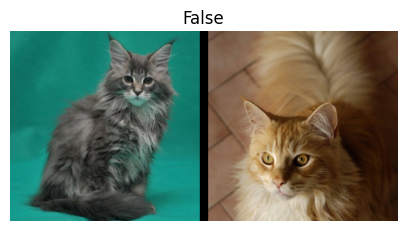

In [ ]:
s2 = Resize(224)(s1)
s2.show()

In [ ]:
def label_func(fname):
  return re.match(r'^(.*)_\d+.jpg$',fname.name).groups()[0]

In [ ]:
class SiameseTransform(Transform):
  def __init__(self, files, label_func, splits):
    self.labels = files.map(label_func).unique()
    self.lbl2files = {l: L(f for f in files if label_func(f)==l)
                      for l in self.labels}
    self.label_func = label_func
    self.valid = {f: self._draw(f) for f in files[splits[1]]}

  def encodes(self,f):
    f2,t = self.valid.get(f, self._draw(f))
    img1, img2 = PILImage.create(f), PILImage.create(f2)
    return SiameseImage(img1, img2, t)

  def _draw(self, f):
    same = random.random() <0.5
    cls = self.label_func(f)
    if not same:
      cls = random.choice(L(l for l in self.labels if l!= cls))
    return random.choice(self.lbl2files[cls]), same


torch.Size([3, 500, 479])
3
500


<Axes: title={'center': 'False'}>

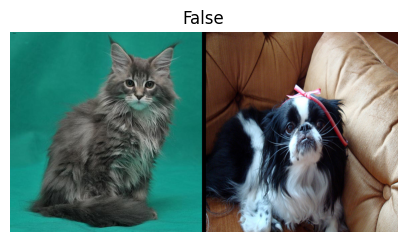

In [ ]:
splits = RandomSplitter()(files)
tfm = SiameseTransform(files, label_func, splits)
tfm(files[0]).show()

torch.Size([3, 282, 500])
3
282


<Axes: title={'center': 'True'}>

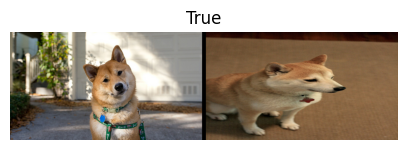

In [ ]:
tls = TfmdLists(files, tfm, splits = splits)
show_at(tls.valid,0)

In [ ]:
dls = tls.dataloaders(after_item=[Resize(224), ToTensor],
                      after_batch = [IntToFloatTensor, Normalize.from_stats(*imagenet_stats)])